In [ ]:
pip install lib-pybroker

# Get Data

In [6]:
from pybroker import YFinance

yfinance = YFinance()
df = yfinance.query(['GOOG', 'MSFT'], start_date='1/1/2022', end_date='1/1/2023')
df.head()

Loading bar data...
[*********************100%***********************]  2 of 2 completed
Loaded bar data: 0:00:01 



,date,symbol,open,high,low,close,volume,adj_close
0,2022-01-03,GOOG,144.475494,145.550003,143.502502,145.074493,25214000,145.074493
1,2022-01-03,MSFT,335.350006,338.000000,329.779999,334.750000,28865100,330.813873
2,2022-01-04,GOOG,145.550507,146.610001,143.816147,144.416504,22928000,144.416504
3,2022-01-04,MSFT,334.829987,335.200012,326.119995,329.010010,32674300,325.141357
4,2022-01-05,GOOG,144.181000,144.298004,137.523499,137.653503,49642000,137.653503


In [ ]:
from pybroker import Alpaca
import os

alpaca = Alpaca(os.environ['ALPACA_API_KEY'], os.environ['ALPACA_API_SECRET'])

df = alpaca.query(
    ['GOOG', 'MSFT'],
    start_date='1/1/2022',
    end_date='1/1/2023',
    timeframe='1m'
)

df

# Caching

In [ ]:
import pybroker

pybroker.enable_data_source_cache('yfinance')

# Custom Data Source

In [ ]:
import pandas as pd
import pybroker
from pybroker.data import DataSource

class CSVDataSource(DataSource):

    def __init__(self):
        super().__init__()
        # Register custom columns in the CSV.
        pybroker.register_columns('rsi')

    def _fetch_data(self, symbols, start_date, end_date, _timeframe):
        df = pd.read_csv('data/prices.csv')
        df = df[df['symbol'].isin(symbols)]
        df['date'] = pd.to_datetime(df['date'])
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Pairs Trading

In [7]:
from pybroker import Strategy, StrategyConfig

In [40]:
def box_trade(ctx):
  # Obtain data on dbx (it will match the same date)
  dbx = ctx.foreign(symbol="DBX", col="close")

  # Wait to have enough data
  if ctx.bars <5:
    return

  # Calculate the 5 day percentage move differences
  box_5d_pct_move = ((ctx.close[-1] - ctx.close[-5]) / ctx.close[-5]) * 100
  dbx_5d_pct_move = ((dbx[-1] - dbx[-5]) / dbx[-5]) * 100

  move_diff = box_5d_pct_move - dbx_5d_pct_move

  # Trading logic
  if move_diff >= 5 and not ctx.short_pos():
    if ctx.long_pos():
      ctx.sell_all_shares

    # The line below deploys 50% of avaialble funds
    ctx.sell_shares = ctx.calc_target_shares(0.5)

  if move_diff <= -5 and not ctx.long_pos():
    if ctx.short_pos():
      ctx.cover_all_shares()

    ctx.buy_shares = ctx.calc_target_shares(0.5)


def dbx_trade(ctx):
  # Obtain data on dbx (it will match the same date)
  box = ctx.foreign(symbol="BOX", col="close")

  # Wait to have enough data
  if ctx.bars <5:
    return

  # Calculate the 5 day percentage move differences
  dbx_5d_pct_move = ((ctx.close[-1] - ctx.close[-5]) / ctx.close[-5]) * 100
  box_5d_pct_move = ((box[-1] - box[-5]) / box[-5]) * 100

  move_diff = dbx_5d_pct_move - box_5d_pct_move

  # Trading logic
  if move_diff >= 5 and not ctx.short_pos():
    if ctx.long_pos():
      ctx.sell_all_shares

    # The line below deploys 50% of available funds
    ctx.sell_shares = ctx.calc_target_shares(0.5)

  if move_diff <= -5 and not ctx.long_pos():
    if ctx.short_pos():
      ctx.cover_all_shares()

    ctx.buy_shares = ctx.calc_target_shares(0.5)

In [41]:
config = StrategyConfig(initial_cash=100_000, max_long_positions=1, max_short_positions=1)
strategy = Strategy(YFinance(), '3/1/2018', '3/1/2023', config)
strategy.add_execution(box_trade, ['BOX'])
strategy.add_execution(dbx_trade, ['DBX'])

result = strategy.backtest(calc_bootstrap=False)

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loading bar data...
[*********************100%***********************]  2 of 2 completed
Loaded bar data: 0:00:00 

Test split: 2018-03-01 00:00:00 to 2023-02-28 00:00:00


100% (1258 of 1258) |####################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


In [42]:
result.portfolio.tail()

,cash,equity,margin,market_value,pnl,fees
date,,,,,,
2023-02-22,171828.26,205440.74,76307.22,198458.38,98458.38,0.0
2023-02-23,171828.26,205123.94,76352.56,198096.24,98096.24,0.0
2023-02-24,171828.26,204458.66,75355.08,198428.44,98428.44,0.0
2023-02-27,171828.26,204284.42,75604.45,198004.83,98004.83,0.0
2023-02-28,171828.26,204141.86,75604.45,197862.27,97862.27,0.0


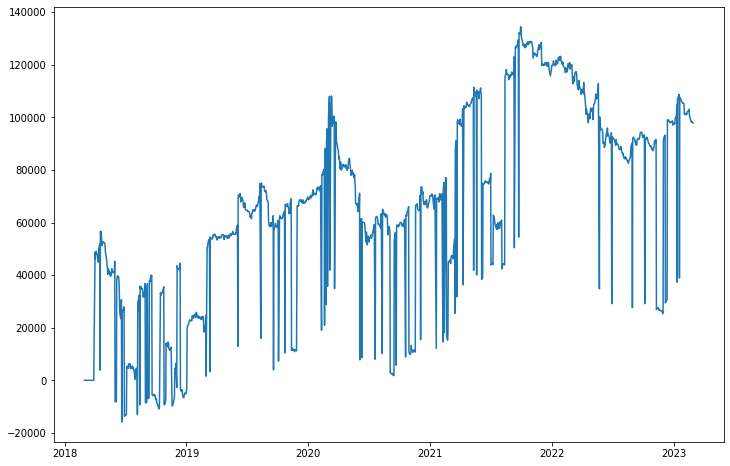

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(result.portfolio.index, result.portfolio['pnl'])

In [44]:
result.metrics_df

,name,value
0,trade_count,123.000000
1,initial_market_value,100000.000000
2,end_market_value,197862.270000
3,total_pnl,39236.360000
4,unrealized_pnl,58625.910000
5,total_return_pct,39.236360
6,total_profit,217256.900000
7,total_loss,-178020.540000
8,total_fees,0.000000
9,max_drawdown,-109107.800000


In [45]:
result.trades.sort_values("id").head()

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar
id,,,,,,,,,,,,
1,long,BOX,2018-04-02,2018-04-17,20.45,21.14,2433,1678.77,3.37,1678.77,11,152.62
2,short,DBX,2018-04-02,2018-04-17,30.35,29.31,1600,1664.00,3.55,3342.77,11,151.27
3,long,DBX,2018-04-17,2018-06-01,29.31,29.82,979,499.29,1.74,3842.06,32,15.60
4,short,BOX,2018-04-18,2018-06-01,21.28,26.19,2447,-12014.77,-18.75,-8172.71,31,-387.57
5,long,BOX,2018-06-01,2018-06-21,26.19,28.59,591,1418.40,9.16,-6754.31,14,101.31


In [46]:
result.positions.head()

,,long_shares,short_shares,close,equity,market_value,margin,unrealized_pnl
symbol,date,,,,,,,
BOX,2018-04-02,2433,0,20.24,49243.92,49243.92,0.0,-510.93
DBX,2018-04-02,0,1600,30.01,0.00,544.00,48016.0,544.00
BOX,2018-04-03,2433,0,20.32,49438.56,49438.56,0.0,-316.29
DBX,2018-04-03,0,1600,31.59,0.00,-1984.00,50544.0,-1984.00
BOX,2018-04-04,2433,0,20.60,50119.80,50119.80,0.0,364.95


# Bootstrap

In [47]:
result = strategy.backtest(calc_bootstrap=True)
result.metrics_df

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loading bar data...
[*********************100%***********************]  2 of 2 completed
Loaded bar data: 0:00:00 

Test split: 2018-03-01 00:00:00 to 2023-02-28 00:00:00


100% (1258 of 1258) |####################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=1000, samples=10000...
Calculated bootstrap metrics: 0:00:01 

Finished backtest: 0:00:02


,name,value
0,trade_count,123.000000
1,initial_market_value,100000.000000
2,end_market_value,197862.270000
3,total_pnl,39236.360000
4,unrealized_pnl,58625.910000
5,total_return_pct,39.236360
6,total_profit,217256.900000
7,total_loss,-178020.540000
8,total_fees,0.000000
9,max_drawdown,-109107.800000


In [48]:
result.bootstrap.conf_intervals

lower     upper
name              conf                     
Log Profit Factor 97.5% -0.317610  0.418663
                  95%   -0.256617  0.356086
                  90%   -0.189773  0.290248
Sharpe Ratio      97.5% -0.055276  0.070137
                  95%   -0.045534  0.061450
                  90%   -0.032782  0.049541

In [49]:
result.bootstrap.drawdown_conf

,amount,percent
conf,,
99.9%,-1747077.23,-99.999341
99%,-1408528.44,-99.993874
95%,-1100119.18,-99.951143
90%,-965136.60,-99.867116


# Walk-forward

In [50]:
result = strategy.walkforward(windows=3, train_size=0.5, lookahead=1)

Backtesting: 2018-03-01 00:00:00 to 2023-03-01 00:00:00

Loading bar data...
[*********************100%***********************]  2 of 2 completed
Loaded bar data: 0:00:00 

Test split: 2019-06-04 00:00:00 to 2020-08-28 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2020-08-31 00:00:00 to 2021-11-26 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2021-11-29 00:00:00 to 2023-02-28 00:00:00


100% (314 of 314) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Setting number of bootstraps to 1.


Calculating bootstrap metrics: sample_size=1000, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:01


In [51]:
result.metrics_df

,name,value
0,trade_count,87.000000
1,initial_market_value,100000.000000
2,end_market_value,184984.550000
3,total_pnl,30156.550000
4,unrealized_pnl,54828.000000
5,total_return_pct,30.156550
6,total_profit,154629.250000
7,total_loss,-124472.700000
8,total_fees,0.000000
9,max_drawdown,-101991.620000


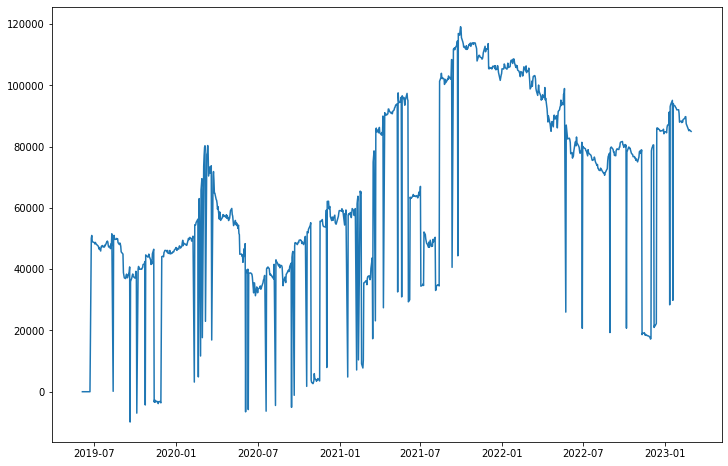

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(result.portfolio.index, result.portfolio['pnl'])

# Indicators

In [ ]:
import numpy as np
from numba import njit

In [ ]:
def cmma(bar_data, lookback):

    @njit  # Enable Numba JIT.
    def vec_cmma(values):
        # Initialize the result array.
        n = len(values)
        out = np.array([np.nan for _ in range(n)])

        # For all bars starting at lookback:
        for i in range(lookback, n):
            # Calculate the moving average for the lookback.
            ma = 0
            for j in range(i - lookback, i):
                ma += values[j]
            ma /= lookback
            # Subtract the moving average from value.
            out[i] = values[i] - ma
        return out

    # Calculate with close prices.
    return vec_cmma(bar_data.close)